In [2]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import cm
import numpy as np
import datetime
import os

pwd = os.getcwd()

# Step 1: Import spectra file

In [57]:
## get spectra data 
year = '2015'
month = '10'
day = '06'
hour = '12'
date = int(year+month+day+hour) # date format: yyyymmddhh

fileName = 'spectra_%s%s%sT%s0000.txt'%(year,month,day,hour)
spectra_files_path = os.path.join(pwd,'..','original_txt_files',fileName) # this path is for GabyS
print('file path =',spectra_files_path)
print('file date =', date)

spec_data = np.loadtxt(spectra_files_path)
Amp = spec_data.T # transpose matrix

file path = /Users/rdchlgs8/Desktop/FRF/spectra/New_python_code/../original_txt_files/spectra_20151006T120000.txt
file date = 2015100612


# Step 2: Find number of freq bins and number of dir bins


In [58]:
## Find number of freq bins and number of dir bins

[NumFreq,NumDir]=np.shape(Amp) # number of freq and dir points
NumFreq = NumFreq-1 # number of freq segments/bins
NumDir = NumDir-1 # number of dir segments/bins

print('File Shape = ', np.shape(Amp))
print('Num Freq bins = ', NumFreq,' & Num Dir bins = ', NumDir)

File Shape =  (62, 72)
Num Freq bins =  61  & Num Dir bins =  71


# Step 3: Assign the complete range of Freq and Dir

In [59]:
## assign the complete range of freq and dir 

complete_f_range = [0.04, 0.4975] # complete Freq range in spectra file (Hz)
dfreq = (complete_f_range[1]-complete_f_range[0])/(NumFreq) # delta freq
complete_Freq = np.arange(complete_f_range[0],
                          complete_f_range[1]+dfreq,dfreq) # complete freq vector

complete_d_range = [0, 355] # complete Dir range in spectra file (deg)
ddire = (complete_d_range[1]-complete_d_range[0])/(NumDir) # delta dir
complete_Dire = np.arange(complete_d_range[0],
                          complete_d_range[1]+ddire,ddire) # complete dir vector

print('dfreq = ', str(dfreq),' & ddire = ', str(ddire))

dfreq =  0.007500000000000001  & ddire =  5.0


# Step 4: Compute the dir spectra and freq spectra for the complete spectra

In [60]:
## compute directional spectra and frequency spectra respectively
Amp_Dir = np.sum(Amp,0)*dfreq ## axis 0 = sum of each column (COL = DIR) 
print('Amp Dir shape = ', np.shape(Amp_Dir))

Amp_Frq = np.sum(Amp,1)*ddire ## axis 1 = sum of each row (ROW = FREQ)
print('Amp Freq shape = ', np.shape(Amp_Frq))

Amp Dir shape =  (72,)
Amp Freq shape =  (62,)


# Step 5: Plot and save complete spectra

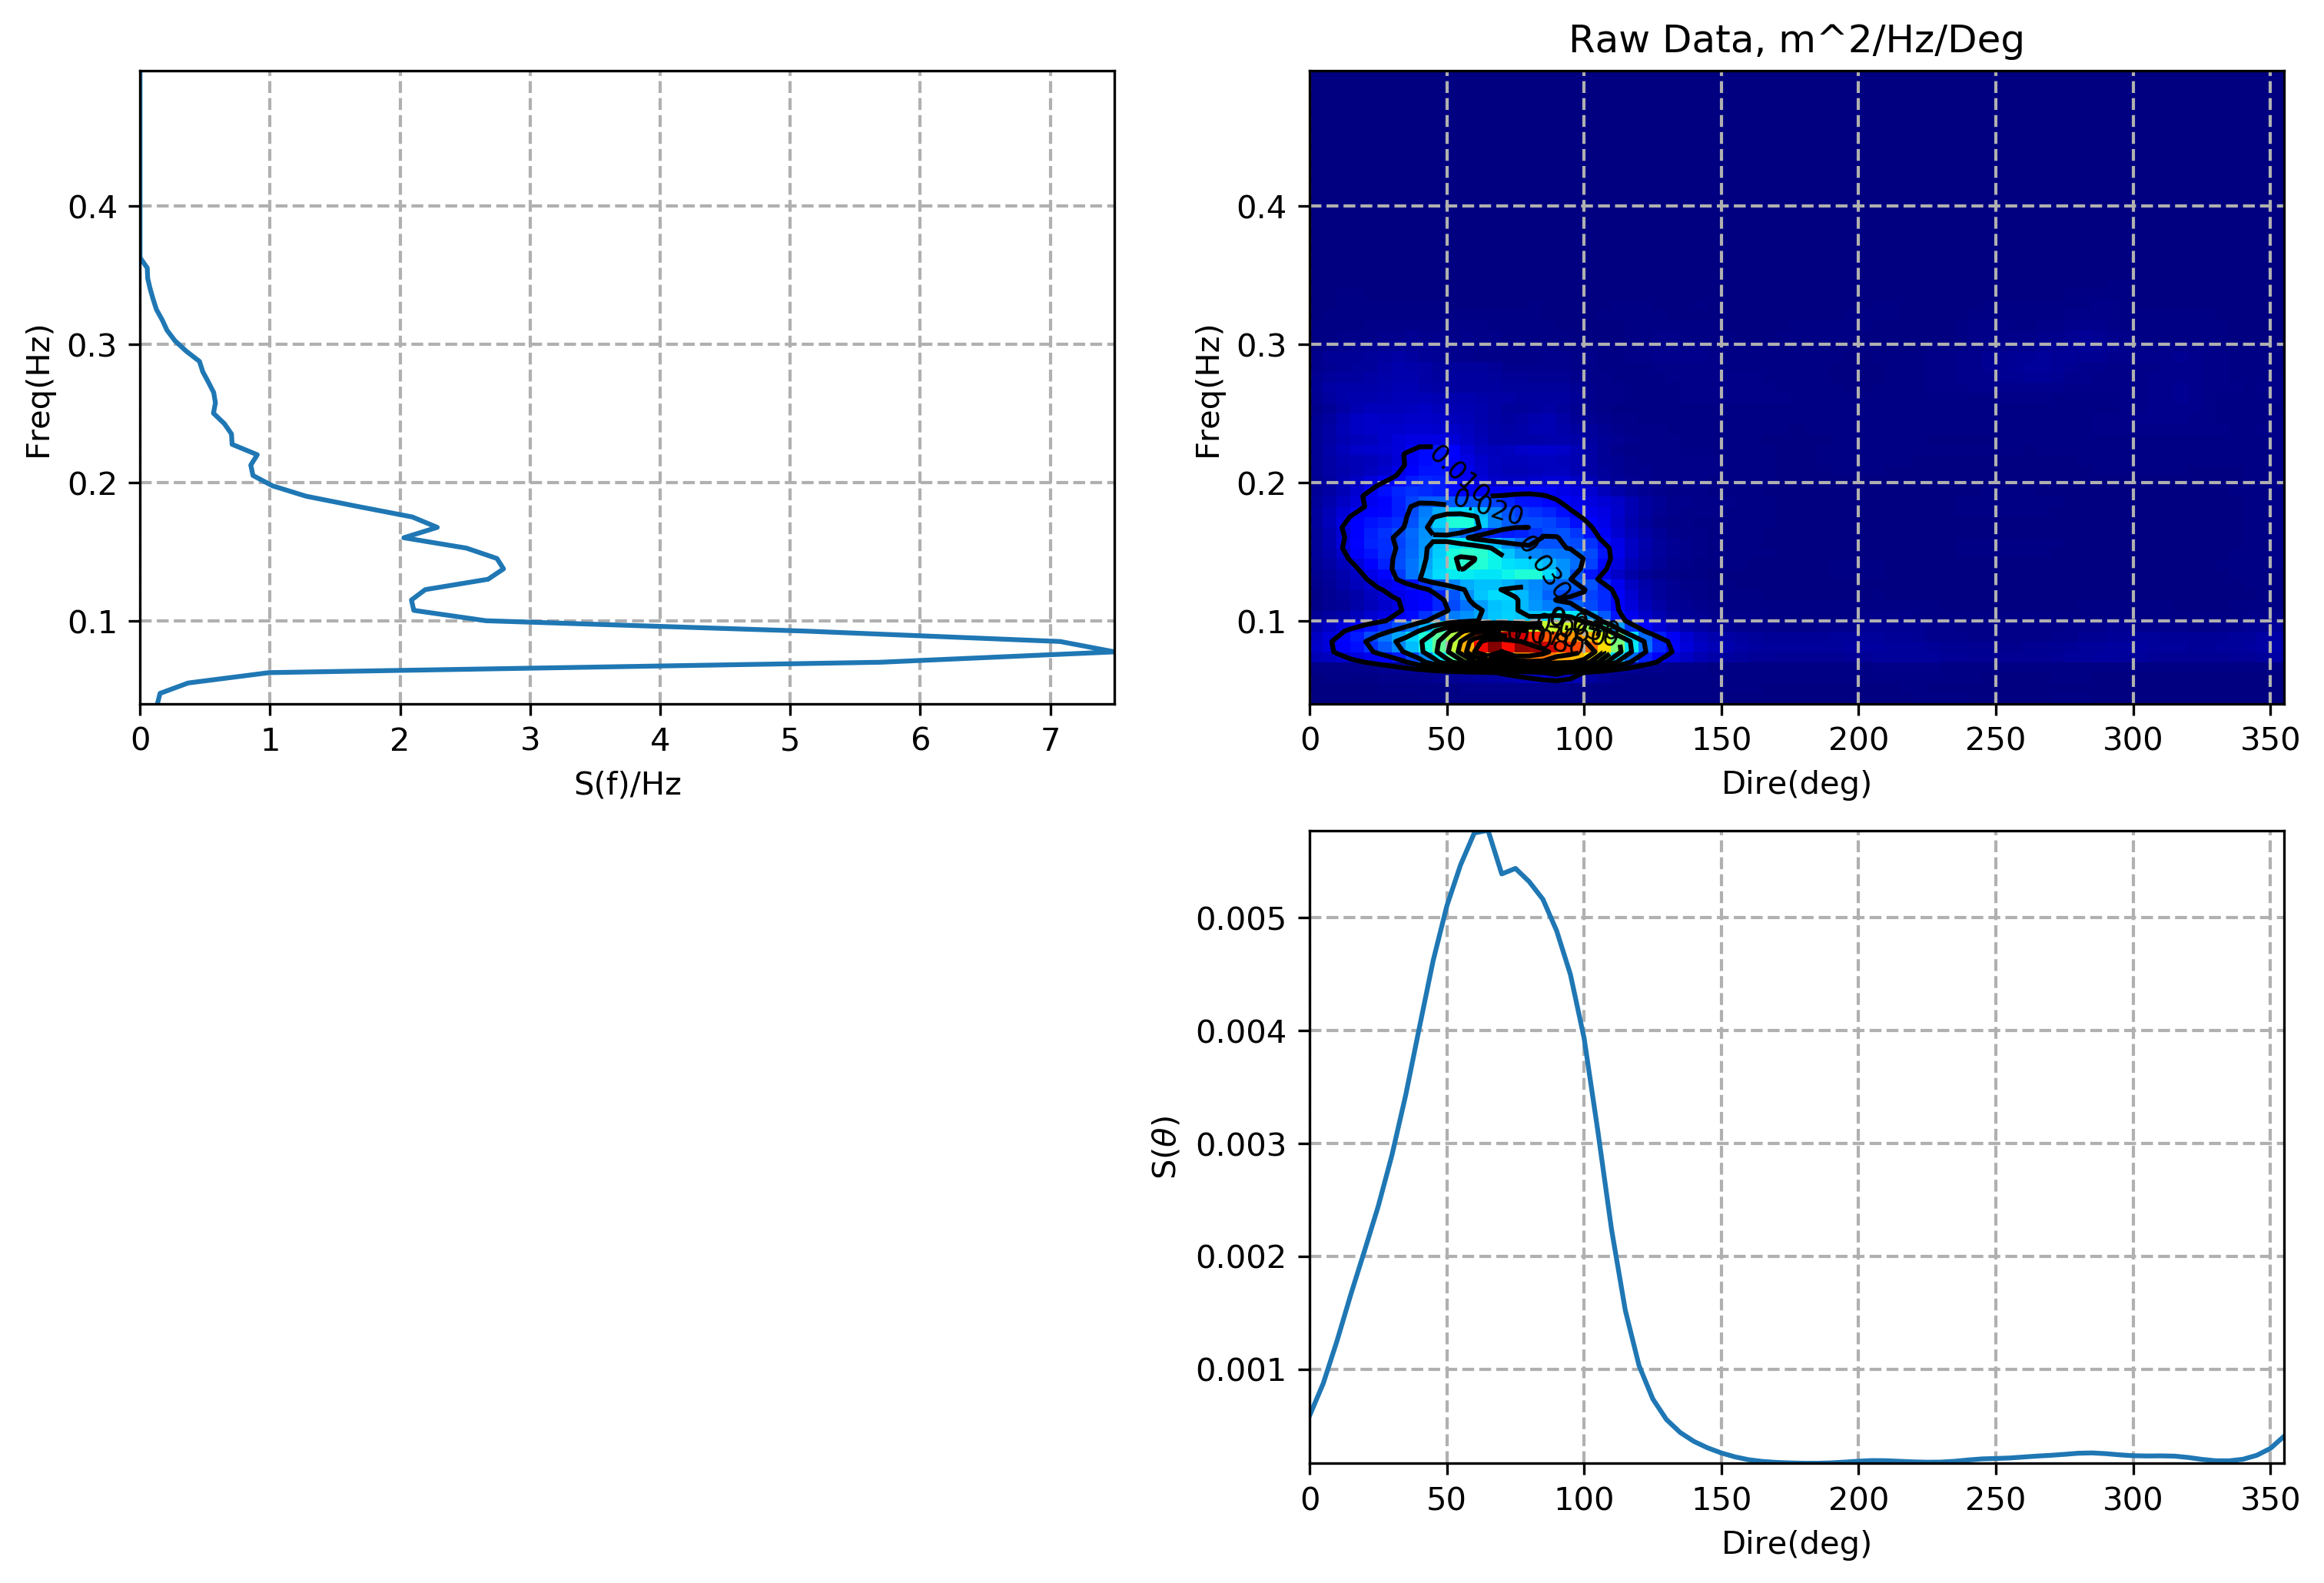

In [61]:
fig = plt.figure(figsize=(12.0,8.0),dpi=300)
ax = fig.add_subplot(2,2,1)
plt.plot(Amp_Frq,complete_Freq)
plt.xlabel('S(f)/Hz')
plt.ylabel('Freq(Hz)')
plt.ylim(min(complete_Freq), max(complete_Freq)) 
plt.xlim(min(Amp_Frq), max(Amp_Frq))
ax.grid(linestyle='--', linewidth=1)
        
ax2 = fig.add_subplot(2,2,4)
plt.plot(complete_Dire,Amp_Dir)
plt.ylabel(r'S($\theta$)')
plt.xlabel('Dire(deg)')
plt.xlim(min(complete_Dire), max(complete_Dire)) 
plt.ylim(min(Amp_Dir), max(Amp_Dir))
ax2.grid(linestyle='--', linewidth=1) 
        
ax3 = fig.add_subplot(2,2,2)
pcol = plt.pcolor(complete_Dire,complete_Freq,Amp,cmap='jet')   
plt.clim(0, 0.1)
CS = plt.contour(complete_Dire,complete_Freq,Amp, 10, colors='k')
plt.clabel(CS, inline=0.5, fontsize=8)
plt.xlabel('Dire(deg)')
plt.ylabel('Freq(Hz)')
plt.title('Raw Data, m^2/Hz/Deg')
ax3.grid(linestyle='--', linewidth=1) 

#display(fig)

# save figure
fileName = 'complete_spec_%d.png'%(int(date))
fig_path = os.path.join(pwd,'FUNWAVE_SPECTRA','complete_fig',fileName)
fig.savefig(fig_path, dpi=fig.dpi) # save figure

# Step 6: Find Peak Freq, Peak Period, and Peak Dir

In [62]:
[peakf,peakd] = np.unravel_index(Amp.argmax(), Amp.shape) 
# ^ find indeces of max/peak value in spectra

PeakFreq = complete_Freq[peakf]
PeakPeriod = 1.0/PeakFreq

peak_dir = complete_Dire[peakd] 

print(' Peak Direction = ', peak_dir,' deg from the TN (Note: For FRF, wave is COMING from that direction)\n', 
      'Peak Freq = ', PeakFreq,' Hz\n',
      'Peak Period = ',PeakPeriod,' s')

 Peak Direction =  65.0  deg from the TN (Note: For FRF, wave is COMING from that direction)
 Peak Freq =  0.0775  Hz
 Peak Period =  12.903225806451614  s


# Step 7: Adjust angles to FUNWAVE format (FF)

In [63]:
original_offset = 71.8 # grid rotation angle [deg] from the True North (TN) to the cross-shore
print('Original FRF grid offset angle = ',str(original_offset),' deg\n')

mod = original_offset%ddire
if mod >= ddire/2:  # adjust rotation angle to the closest angle available in the bins
    offset = np.ceil(original_offset-mod+ddire);
else:
    offset = np.floor(original_offset-mod);

    
# angle with respect to funwave (0 deg is cros-shore, [-] toward south, and [+] toward north)    
main_dir= ((90-offset)-(90-peak_dir)) 

print('if new grid offset = ',str(offset),' deg',
          ' ===> wave main_dir = ',str(main_dir),' deg\n')

d_range=[main_dir-90, main_dir+90] # funwave angle cone
print('FUNWAVE angle cone ==> [main_dir-90, main_dir+90] = ',d_range)  

Dire_model = np.arange(d_range[0],d_range[1]+ddire,ddire) # new truncated direction vector in FF  

d_range_TN = [peak_dir-90, peak_dir+90] # TN angle cone 
Dire_TN = np.arange(d_range_TN[0],d_range_TN[1]+ddire,ddire) # new direction vector in TN 

DIRE = np.zeros(np.shape(Dire_TN)) # same as Dire_TN, but without the negative values
for i, angle in enumerate(Dire_TN):
    if angle<0:
        DIRE[i] = 360 + angle    
    else:
        DIRE[i] = angle
        
print('\nTN angle cone ==> [peak_dir-90, peak_dir+90] = ',d_range_TN, '==> [%3.1f, %3.1f]\n\n'%(DIRE[0],DIRE[-1])) 

print('Dire vector (FRF from the TN) = ',DIRE,'\n\nDire vector (FF) = ',Dire_model)

Original FRF grid offset angle =  71.8  deg

if new grid offset =  70.0  deg  ===> wave main_dir =  -5.0  deg

FUNWAVE angle cone ==> [main_dir-90, main_dir+90] =  [-95.0, 85.0]

TN angle cone ==> [peak_dir-90, peak_dir+90] =  [-25.0, 155.0] ==> [335.0, 155.0]


Dire vector (FRF from the TN) =  [335. 340. 345. 350. 355.   0.   5.  10.  15.  20.  25.  30.  35.  40.
  45.  50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100. 105. 110.
 115. 120. 125. 130. 135. 140. 145. 150. 155.] 

Dire vector (FF) =  [-95. -90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30.
 -25. -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.
  45.  50.  55.  60.  65.  70.  75.  80.  85.]


# Step 8: Define the number of Freq and Dir points that will be used in the model


In [25]:
f_range = [0.04, 0.3775] # desired freq range (Hz)
Freq = np.arange(f_range[0],f_range[1]+dfreq,dfreq) # desired freq vector

MaxFreqNum = len(Freq) # max number of desired Frq points (should be 46 for FRF case) 
MaxDireNum = len(DIRE) # max number of desired Dir points (should be 31 for FRF case)

print('available frq points (NumFreq + 1) = ', NumFreq + 1,
      '\ndesired frq points (MaxFreqNum)= ', MaxFreqNum,'\n')
print('available dir points (NumDir + 1) = ', NumDir + 1,
      '\ndesired dir points (MaxDireNum) = ', MaxDireNum,'\n')

NFreq = min(NumFreq,MaxFreqNum) # select min value between available and desired number of Freq bins
NDir  = min(NumDir,MaxDireNum)  # select min value between available and desired number of Dir bins
print('Model number of freq points (NFreq) = ', str(NFreq),
      '\nModel number of dir points (NDir) = ', str(NDir))

available frq points (NumFreq + 1) =  62 
desired frq points (MaxFreqNum)=  46 

available dir points (NumDir + 1) =  72 
desired dir points (MaxDireNum) =  37 

Model number of freq points (NFreq) =  46 
Model number of dir points (NDir) =  37


# Step 9: Truncate Spectra

In [26]:
n_peakf = np.arange(max(0,peakf-np.floor(NFreq/2)-1),
                    min(NumFreq,peakf+np.floor(NFreq/2))+1)   # truncated freq index range 
print('\nTruncated freq indeces = ', n_peakf)

n_peakd = np.zeros(MaxDireNum)  # vector with angle cone indeces (truncated dir index range)
for j in range(MaxDireNum):
    for k, angle in enumerate(complete_Dire):
        if angle == DIRE[j]:
            n_peakd[j] = int(k) - len(complete_Dire)
        else:
            pass
print('\nTruncated dir indeces = ', n_peakd,'\n')

Freq_model = Freq[n_peakf.astype(int)]  # extract the freq on the truncated index rages



Amp_model = Amp[n_peakf[0].astype(int):n_peakf[-1].astype(int)+1,
                n_peakd.astype(int)]  # extract the amp on the truncated index ranges
    

Amp_Dir_model = np.sum(Amp_model,0)*dfreq  # truncated directional spectra

Amp_Frq_model = np.sum(Amp_model,1)*ddire  # truncated frequency spectra


## verify that the truncated matrix dimensions are correct
print('Shape of model freq vector (Freq_Model) = ', str(np.shape(Freq_model)))
print('Shape of truncated frequency spectra (Amp_Freq_Model) = ', str(np.shape(Amp_Frq_model)))
if np.shape(n_peakf) == np.shape(Amp_Frq_model):
    print('Freq_model and Amp_Freq_Model have the same length.')
else:
    print('Freq_model and Amp_Freq_Model DO NOT have the same length!!! VERIFY DATA!!!!\n')


print('\nShape of model dire vector (Dire_model)= ', str(np.shape(Dire_model)))
print('Shape of truncated directional spectra (Amp_Dir_Model) = ', str(np.shape(Amp_Dir_model)))
if np.shape(n_peakd) == np.shape(Amp_Dir_model):
    print('Dir_model and Amp_Dir_Model have the same length.\n')
else:
    print('Dir_model and Amp_Dir_Model DO NOT have the same length!!! VERIFY DATA!!!!\n')
    



Truncated freq indeces =  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]

Truncated dir indeces =  [ -4.  -3.  -2.  -1. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63.
 -62. -61. -60. -59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49.
 -48. -47. -46. -45. -44. -43. -42. -41. -40.] 

Shape of model freq vector (Freq_Model) =  (30,)
Shape of truncated frequency spectra (Amp_Freq_Model) =  (30,)
Freq_model and Amp_Freq_Model have the same length.

Shape of model dire vector (Dire_model)=  (37,)
Shape of truncated directional spectra (Amp_Dir_Model) =  (37,)
Dir_model and Amp_Dir_Model have the same length.



# Step 10: Plot truncated spectra


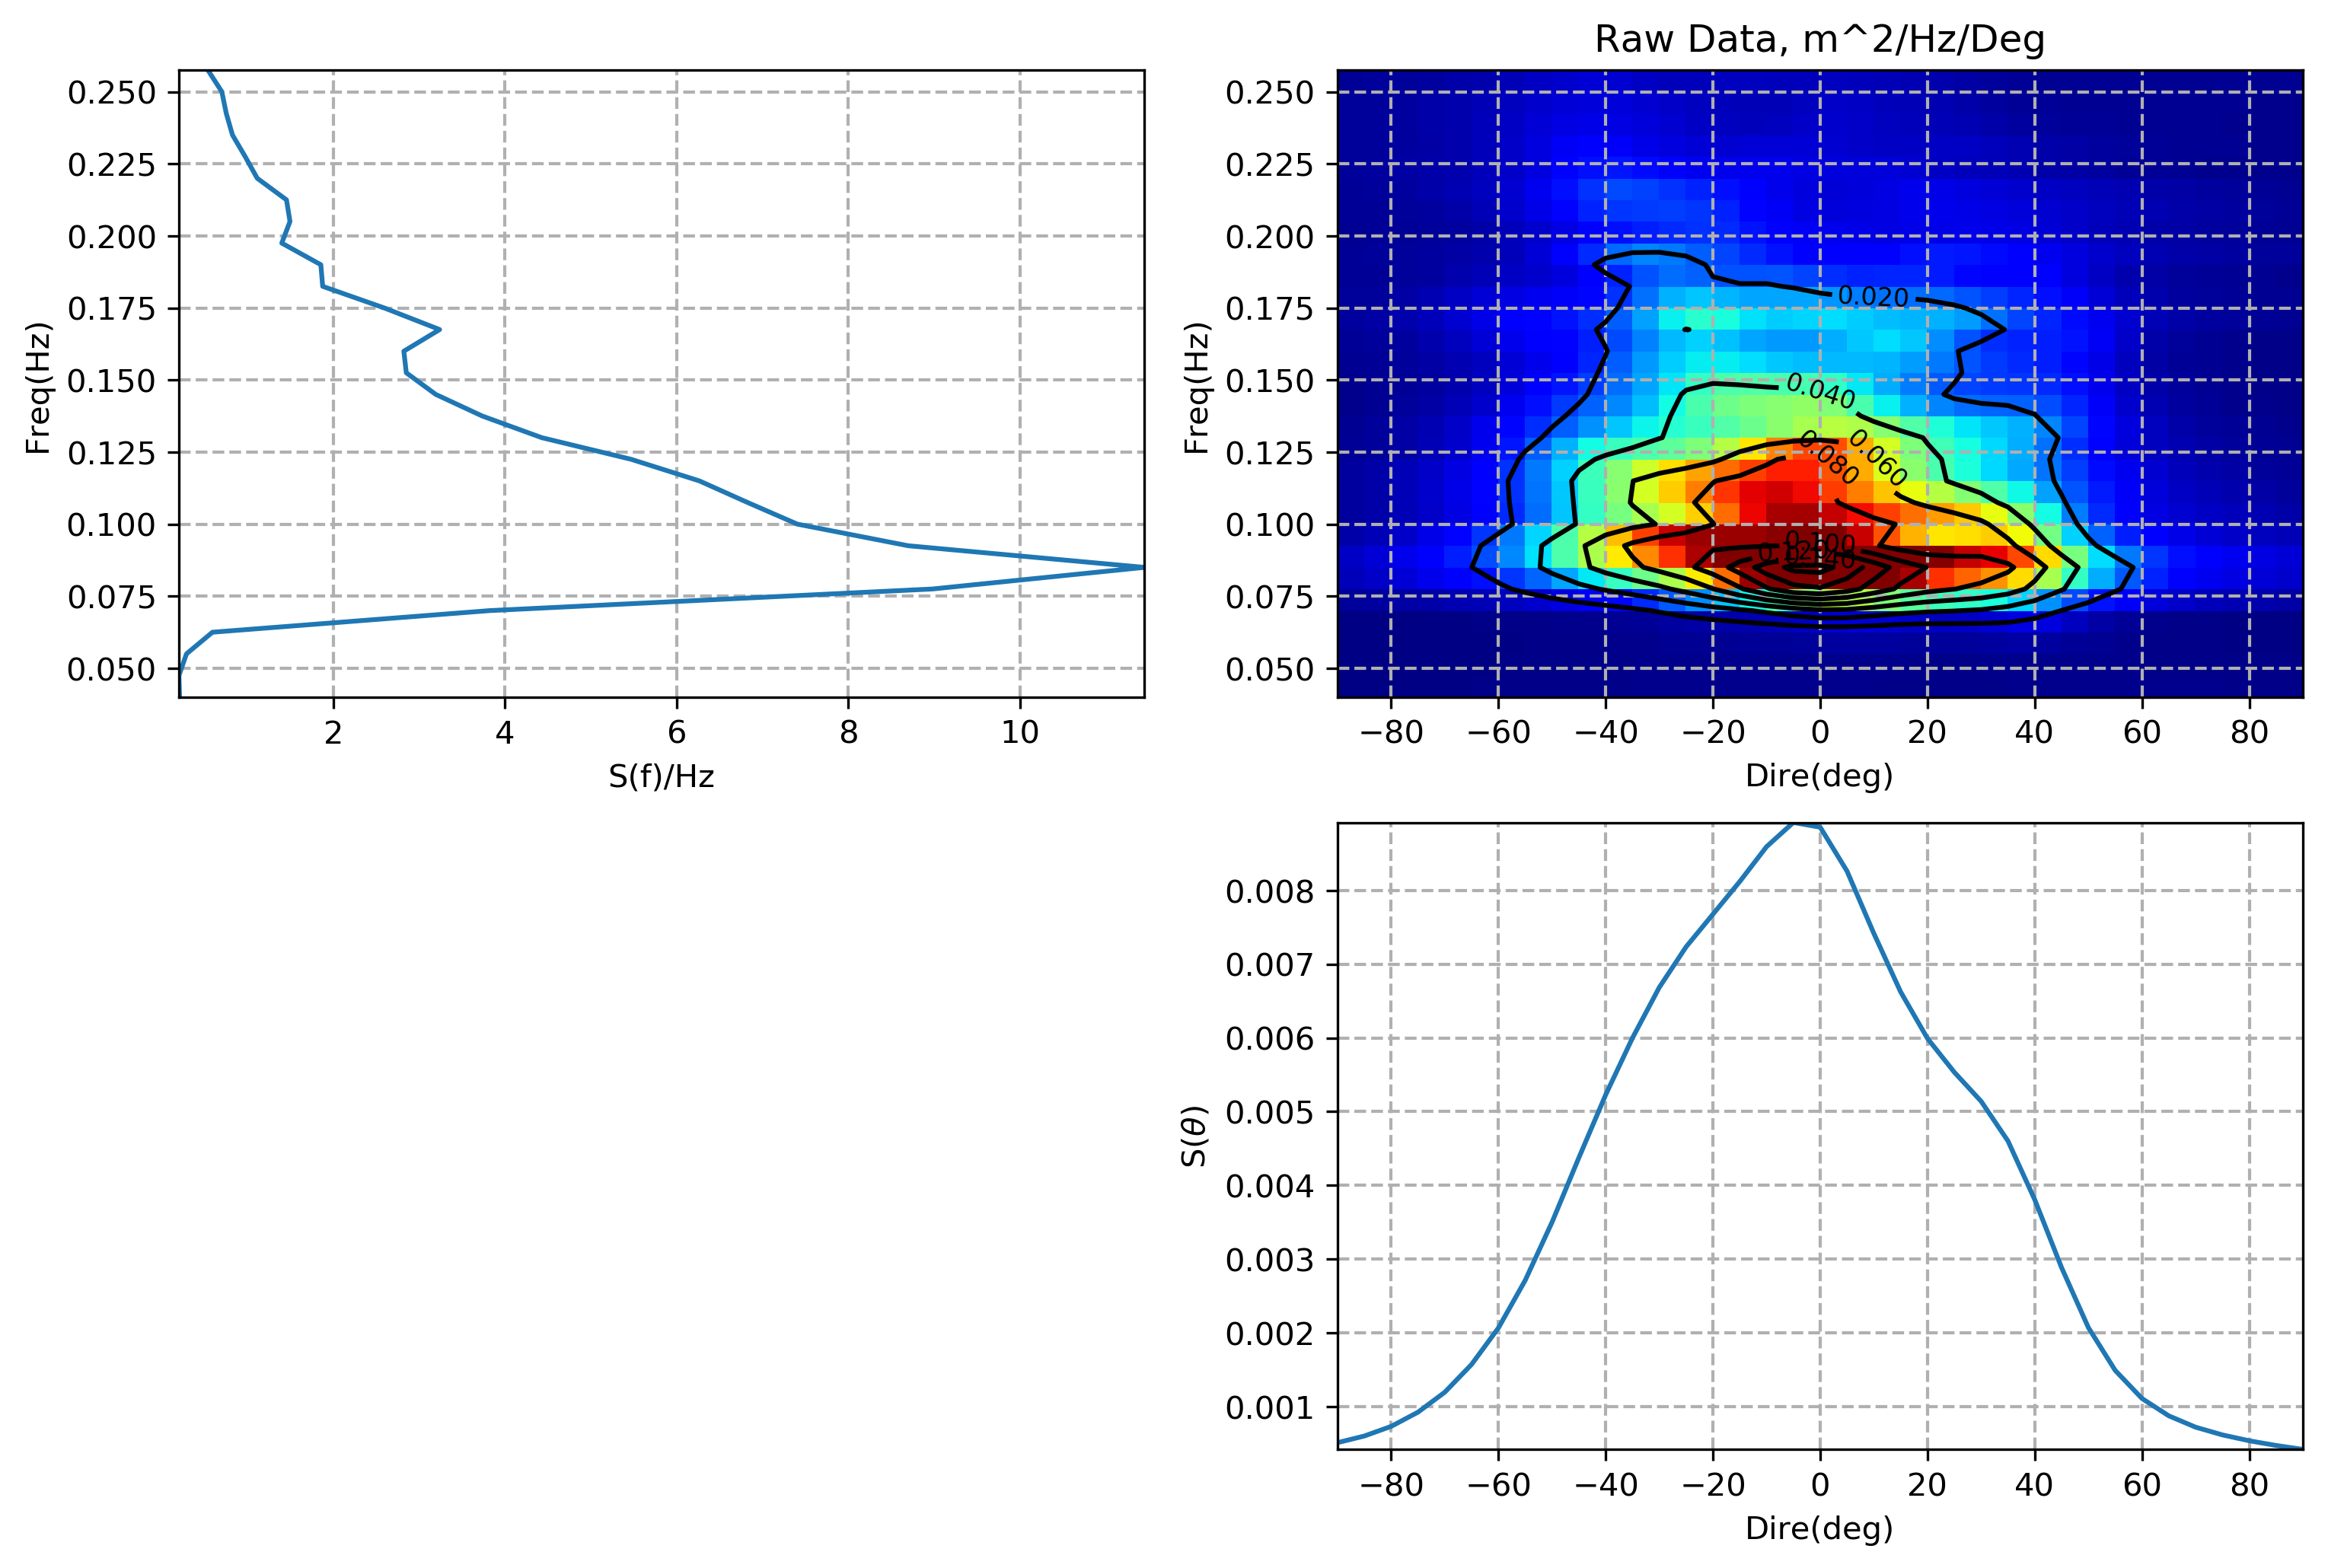

In [27]:
## plot truncated spectra

fig = plt.figure(figsize=(12.0,8.0),dpi=300)
ax = fig.add_subplot(2,2,1)
plt.plot(Amp_Frq_model,Freq_model)
plt.xlabel('S(f)/Hz')
plt.ylabel('Freq(Hz)')
plt.ylim(min(Freq_model), max(Freq_model)) 
plt.xlim(min(Amp_Frq_model), max(Amp_Frq_model))
ax.grid(linestyle='--', linewidth=1)
        
ax2 = fig.add_subplot(2,2,4)
plt.plot(Dire_model,Amp_Dir_model)
plt.ylabel(r'S($\theta$)')
plt.xlabel('Dire(deg)')
plt.xlim(min(Dire_model), max(Dire_model)) 
plt.ylim(min(Amp_Dir_model), max(Amp_Dir_model))
ax2.grid(linestyle='--', linewidth=1) 
        
ax3 = fig.add_subplot(2,2,2)
pcol = plt.pcolor(Dire_model,Freq_model,Amp_model,cmap='jet')   
plt.clim(0, 0.1)
CS = plt.contour(Dire_model,Freq_model,Amp_model, 10, colors='k')
plt.clabel(CS, inline=0.5, fontsize=8)
plt.xlabel('Dire(deg)')
plt.ylabel('Freq(Hz)')
plt.title('Raw Data, m^2/Hz/Deg')
ax3.grid(linestyle='--', linewidth=1) 

#display(fig)

# save figure
fileName = 'truncated_spec_%d.png'%(int(date))
fig_path = os.path.join(pwd,'FUNWAVE_SPECTRA','truncated_fig',fileName)
fig.savefig(fig_path, dpi=fig.dpi) # save figure

# Step 11: Compute Total Energy, Hmo and Hrms

In [28]:
## Compute total energy density, Hrms & Hsig (from complete spectra)

totalE_complete = np.sum(Amp*dfreq*ddire)  
Hrms_complete = np.sqrt(totalE_complete*8)
Hsig_complete = np.sqrt(2)*Hrms_complete 

print('For complete spectra ===> totalE = ',
      str(totalE_complete),'J/(m^3), Hrms = ', str(Hrms_complete),'m'
      ', & Hsig = ', str(Hsig_complete),'m\n')

## Compute model energy density, Hrms & Hsig (from truncated spectra)

totalE_model = np.sum(Amp_model*dfreq*ddire)  
Hrms_model = np.sqrt(totalE_model*8)
Hsig_model = np.sqrt(2)*Hrms_model 

print('For truncated spectra ===> totalE = ',
      str(totalE_model),'J/(m^3), Hrms = ', str(Hrms_model),'m'
      ', & Hsig = ', str(Hsig_model),'m\n')

## Compare truncated values to the total values

TotalE_error = abs((totalE_model - totalE_complete)/totalE_complete)*100
Hrms_error = abs((Hrms_model - Hrms_complete)/Hrms_complete)*100
Hsig_error = abs((Hsig_model - Hsig_complete)/Hsig_complete)*100

print('TotalE_%error = ', TotalE_error,
      '% \nHrms_%error =  ', Hrms_error,
      '% \nHsig_%error =  ', Hsig_error,'%')



For complete spectra ===> totalE =  0.8084329273077375 J/(m^3), Hrms =  2.5431208029627497 m, & Hsig =  3.5965159303030765 m

For truncated spectra ===> totalE =  0.720348558499875 J/(m^3), Hrms =  2.400580860541673 m, & Hsig =  3.39493401055131 m

TotalE_%error =  10.89569286857268 % 
Hrms_%error =   5.604922198545058 % 
Hsig_%error =   5.604922198545054 %


# Step 12: Write 1D Spectra File

In [29]:
## write 1d spectra file
amp_frq_bin= np.sqrt(Amp_Frq_model*dfreq*8.0)/2.0;

wave1d = 'wave1d_%d.txt'%(int(date))
out_path = os.path.join(pwd,'FUNWAVE_SPECTRA','1D_files',wave1d)
fileOut = open(out_path,'w')

header1 = str(len(Freq_model))+' '+str(1)+' - NumFreq NumDir \n'
header2 = str(PeakPeriod)+ ' - PeakPeriod \n'

fileOut.write(header1)
fileOut.write(header2)

for f in Freq_model:
    fr = str("%.4f" % f)+' - Freq \n'
    fileOut.write(fr)

d = 0
dr = str("%.4f" % d)+' - Dire \n'
fileOut.write(dr)

for i in range(len(amp_frq_bin)):
    ap = str("%.8f" % amp_frq_bin[i])+'\t'
    fileOut.write(ap)
    fileOut.write('\n')

fileOut.close()

# Step 13: Write 2D Spectra File

In [30]:
## write 2d spectra file
Amp_input = np.sqrt(Amp_model*dfreq*ddire*8.0)/2.0
Amp_input = Amp_input.T


wave2d = 'wave2d_%d.txt'%(int(date))
out_path = os.path.join(pwd,'FUNWAVE_SPECTRA','2D_files',wave2d)
fileOut = open(out_path,'w')

header1_2d = str(len(Freq_model))+' '+str(len(Dire_model))+' - NumFreq NumDir \n'
header2_2d = str(PeakPeriod)+ ' - PeakPeriod \n'

fileOut.write(header1_2d)
fileOut.write(header2_2d)

for f in Freq_model:
    fr = str("%.4f" % f)+' - Freq \n'
    fileOut.write(fr)

for d in Dire_model:
    dr = str("%.4f" % d)+' - Dire \n'
    fileOut.write(dr)

for i in range(len(Amp_input)):
    for j in range(len(Amp_input[i])):
        ap = str("%.8f" % Amp_input[i][j])+'\t'
        fileOut.write(ap)
    fileOut.write('\n')    
    
fileOut.close()